# Experience 3: collapse of a truncated sphere using the TREECODE


In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D

### Generating the truncated sphere

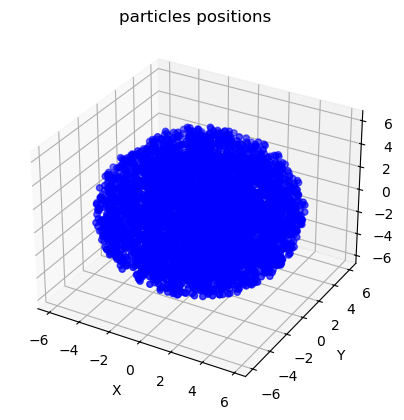

In [2]:
a=6 #radius of the sphere
N=5000 #number of particles

#sample of the radii
P=np.random.uniform(0, 1, N)
r=[]
r=a*P**(1/3)
#plt.hist(r, bins=50, density=True)
#plt.show()

#sample of phi
phi=np.random.uniform(0, 2*np.pi, N)
#plt.hist(phi, bins=50, density=True) #IS IT NORMALIZED??
#plt.title('phi distribution')
#plt.show()

#sample of theta
P1=np.random.uniform(0, 1, N)
theta=[]
for i in range(0, N):
    theta=np.append(theta, math.acos(1-2*P1[i]))
#plt.hist(theta, bins=50, density=True)
#plt.show()

x=[]
y=[]
z=[]

#conevrting the positions from spherical coords to cartesian ones (because the code works with cartesian coords)
for i in range(0, N):
    x=np.append(x, r[i]*math.sin(theta[i])*math.cos(phi[i]))
    y=np.append(y, r[i]*math.sin(theta[i])*math.sin(phi[i]))
    z=np.append(z, r[i]*math.cos(theta[i]))

#verify that the points form a sphere (of radius=a)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='b', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

'''
ax.set_xlim(2.75, 2.85)  
ax.set_ylim(-3.40, 1)  
ax.set_zlim(-2.90, -2.65)
'''
plt.title('particles positions')
plt.show()

### Save them into an input file

In [3]:
starting_time=0
num_dimensions=3
m=np.ones(N) #mass of each particle in internal units 

#initial velocities (all the particles are at rest at the beginning)
vx=np.zeros(N)
vy=np.zeros(N)
vz=np.zeros(N)

#file for the C code
with open("Treecode5000.in", "w") as f:     
    print(N, num_dimensions, starting_time, sep="\n", file=f)
    np.savetxt(f, np.column_stack([m]), delimiter=" ")  #x, y, z, vx, vy, vz]), delimiter=" ")
    np.savetxt(f, np.column_stack([x, y, z]), delimiter=" ")
    np.savetxt(f, np.column_stack([vx, vy, vz]), delimiter=" ")

Comand: ./treecode in=Treecode5000.in out=out_tree5000_20.out dtime=0.05 eps=0.1 theta=0.1 tstop=1 dtout=0.05 > energy5000_20.log

### Compute the expected quantity

In [3]:
#Conversion in IU
G_p = 6.67259e-8 #G in cgs
M_sun = 1.9891e33 #solar mass in g
R_sun = 6.9598e10 #solar radius in cm 
year = 3.14159e7
ly = 9.463e17 #light year in cm
parsec = 3.086e18 #parsec in cm
AU = 1.496e13 #astronomical unit in cm

def v_IU(v_p, M_p=M_sun, r_p=AU):    #because 1 M_i = 1 M_sun and 1 r_i = 1 AU
    return np.sqrt(r_p / (G_p * M_p)) * v_p

def t_IU(t_p, M_p=M_sun, r_p=AU):
    return ((t_p / r_p)*(np.sqrt((G_p * M_p)/r_p)))

t_iu_yr = 6.251839 #1 yr is 6.251839 IU
v_iu_cgs = 3.357e-7 #1 cm/s is 3.357e-7 IU

M = 5000 #Total mass in IU that corresponds to 5000 solar masses
M_i = M / N #Single particle mass, that is 1 IU

In [4]:
#Compute the dynamical time and the collapse time in years

volume = 4/3 * np.pi * a**3

density_0 = M / volume #Initial density

t_dyn_IU = np.sqrt(3 * np.pi / (16 * density_0))  #G_i=1!

t_coll_IU = t_dyn_IU / np.sqrt(2) 

#Conversion in physical units
t_dyn = t_dyn_IU / t_iu_yr

t_coll = t_coll_IU / t_iu_yr

#eps = 1e-4 * (volume / N)**(-1/3)
#print("Epsilon = " + str(eps))

print("Dynamical time:" + f"{t_dyn: .4f}" + " yr")
print("Dynamical time (IU):"  + f"{t_dyn_IU: .4f}") 
print("Collapse time:" + f"{t_coll: .5f}" + " yr")
print("Collapse time (IU): " + f"{t_coll_IU: .5f}")
print("Initial density (IU):" + f"{density_0: .3e}")

Dynamical time: 0.0522 yr
Dynamical time (IU): 0.3265
Collapse time: 0.03693 yr
Collapse time (IU):  0.23086
Initial density (IU): 5.526e+00


### Get the data

In [5]:
#per il momento sono tutti in IU
def GetData(filename, N):
    file_output = open(filename, "r")
    output = file_output.read().splitlines()
    data = []
    time = []
    
    for i in range(3, len(output), 3 * N + 3):
        for j in range(N, 3 * N):
            data.append(output[i + j].split())
        
        time.append(float(output[i - 1]))
        
    #Convert the time in years
    #time = np.array(time) / t_iu_yr
    
    file_output.close()
    
    return np.array(data), np.array(time)

#Get the evolution in time from the data in the CM frame

def GetCoords(data, t, N):
    
    #Get the coordinates
    
    x_ext, y_ext, z_ext = [], [], []
    
    for i in range(0, len(t)):
        x_ext.append([])
        y_ext.append([])
        z_ext.append([])
        
    #Every row contains the coordinate of the i-th particle, every column contains its evolution in time
    
    row = 0
    
    for i in range(0, len(data), 2 * N):    
        for j in range(0, N):
            x_ext[row].append(float(data[i + j][0]))
            y_ext[row].append(float(data[i + j][1]))
            z_ext[row].append(float(data[i + j][2]))
        
        row += 1
    
    #Convert the coordinates to the CM frame
        
    x_ext = np.array(x_ext)
    y_ext = np.array(y_ext)
    z_ext = np.array(z_ext)
    
    x_CM = M_i * np.sum(x_ext, axis=1) / M   #le masse sono tutte uguali
    y_CM = M_i * np.sum(y_ext, axis=1) / M
    z_CM = M_i * np.sum(z_ext, axis=1) / M
    
    x = x_ext - x_CM[0]
    y = y_ext - y_CM[0]
    z = z_ext - z_CM[0]

    return x, y, z


#Get the velocities in time in the CM frame

def GetVelocities(data, t, N):
    
    #Get the coordinates
    
    vx_ext, vy_ext, vz_ext = [], [], []
    
    for i in range(0, len(t)):
        vx_ext.append([])
        vy_ext.append([])
        vz_ext.append([])
        
    #Every row contains the coordinate of the i-th particle, every column contains its evolution in time
    
    row = 0
    
    for i in range(N, len(data), 2 * N):    
        for j in range(0, N):
            vx_ext[row].append(float(data[i + j][0]))
            vy_ext[row].append(float(data[i + j][1]))
            vz_ext[row].append(float(data[i + j][2]))
        
        row += 1
    
    #Convert the coordinates to the CM frame
        
    vx_ext = np.array(vx_ext)
    vy_ext = np.array(vy_ext)
    vz_ext = np.array(vz_ext)
    
    vx_CM = M_i * np.sum(vx_ext, axis=1) / M
    vy_CM = M_i * np.sum(vy_ext, axis=1) / M
    vz_CM = M_i * np.sum(vz_ext, axis=1) / M
    
    K_CM = M * (vx_CM**2 + vy_CM**2 + vz_CM**2) / 2   #energia cinetica del centro di massa 
    
    vx = vx_ext - vx_CM[0]
    vy = vy_ext - vy_CM[0]
    vz = vz_ext - vz_CM[0]

    v_CM = np.sqrt(vx_CM**2 + vy_CM**2 + vz_CM**2)

    return vx, vy, vz, K_CM, v_CM

In [6]:
data, t = GetData("out_tree5000_20.out", N)
x, y, z = GetCoords(data, t, N)
vx, vy, vz, K_CM, v_CM = GetVelocities(data, t, N)

### Check how the particles move

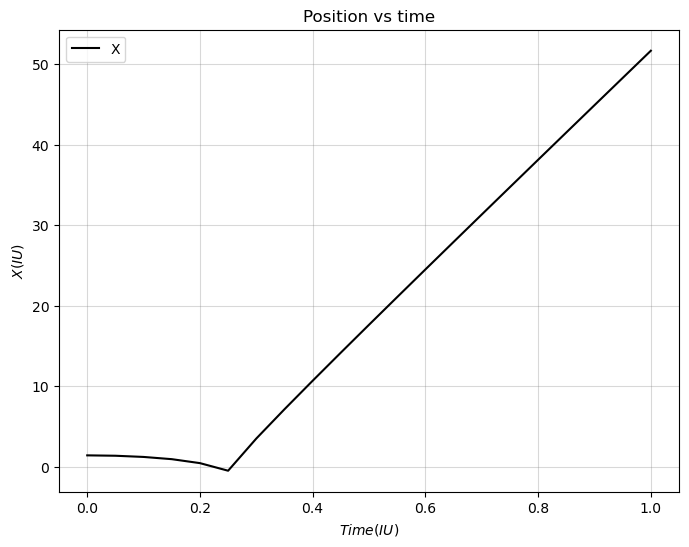

In [19]:
fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.gca()
ax1.grid(alpha=0.3, c = 'grey')
ax1.set_xlabel('$Time(IU)$')
ax1.set_ylabel('$X(IU)$')
x_1 = np.zeros(len(t))
y_1 = np.zeros(len(t))
z_1 = np.zeros(len(t))
for i in range(len(t)):
    x_1[i] = x[i][0]
    y_1[i] = y[i][0]
    z_1[i] = z[i][0]
    
ax1.plot(t, x_1, label = 'X', c= 'black')
ax1.set_title('Position vs time')
ax1.legend()


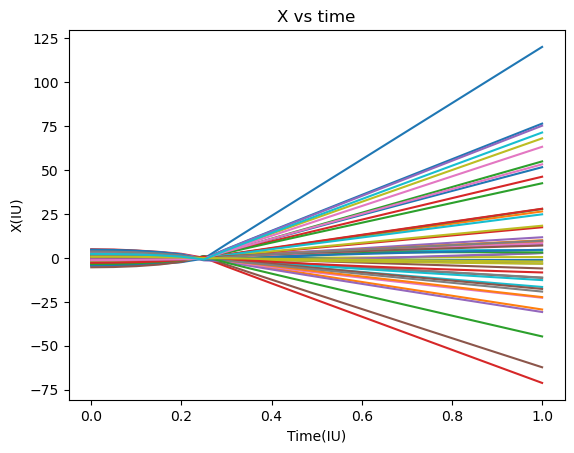

In [20]:
plt.title("X vs time")
plt.xlabel("Time(IU)")
plt.ylabel("X(IU)")
for j in range(0, N, 100):
    for i in range(len(t)):
        x_1[i] = x[i][j]
    plt.plot(t, x_1)

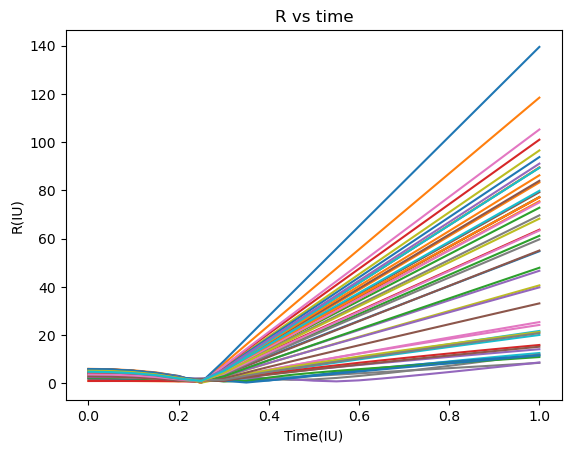

In [7]:
r = np.sqrt(x**2 + y**2 + z**2)
plt.title("R vs time")
plt.xlabel("Time(IU)")
plt.ylabel("R(IU)")

r_s = np.zeros(len(t))

for j in range(0, N, 100):
    for i in range(len(t)):
        r_s[i] = r[i][j]
    plt.plot(t, r_s)

### Computing the energies from the snapshots

In [8]:
# We can try to compute the kinetic energy at each step 
K_i =  M_i * (vx**2 + vy**2 + vz**2) / 2

K_tot = np.zeros(len(K_i))
for i in range(len(K_i)):
    K_tot[i] = np.sum(K_i[i])

In [9]:
#Distances bt the points
dist = np.zeros(len(x))
distances = 0
for k in range(len(x)):
    print(k)
    dist[k] = 0 
    for i in range(N):
        for j in range(i + 1, N):  # Ciclo per ogni particella j, evitando duplicati
            # Calcola la distanza tra le particelle i e j al frame k
            distance = np.sqrt((x[k, i] - x[k, j])**2 + 
                               (y[k, i] - y[k, j])**2 + 
                               (z[k, i] - z[k, j])**2)
            # Verifica che la distanza sia un numero valido prima di calcolare il reciproco
            if distance != 0:  # Evita la divisione per zero
                dist[k] += 1 / distance  #

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [10]:
#Potential energies
U_tot = np.zeros(len(x))
for i in range(len(x)):
    U_tot[i] = -M_i**2*dist[i] #G_i=1

#Total energy
E_tot = U_tot+K_tot

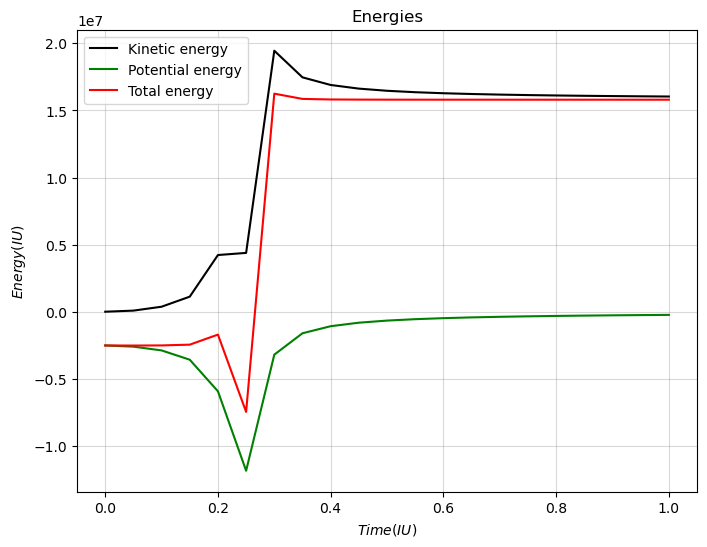

In [11]:
fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.gca()
ax1.grid(alpha=0.3, c = 'grey')
ax1.set_xlabel('$Time(IU)$')
ax1.set_ylabel('$Energy(IU)$')
ax1.plot(t, K_tot, label = 'Kinetic energy', c= 'black')
ax1.plot(t, U_tot, label = 'Potential energy', c= 'green')
ax1.plot(t, E_tot, label = 'Total energy', c= 'red')
ax1.set_title('Energies')
ax1.legend()

### Get the energies from log file and plot them

In [12]:
def GetEnergy(filename, N, K_CM):
    file_output = open(filename, "r")
    output = np.array(file_output.read().splitlines())
    
    idx = np.where(output == output[9])[0] #Find the row with T and U
    
    K = []
    U = []
    
    for i in idx:
        K.append(float(output[i + 1].split()[1]))
        U.append(-float(output[i + 1].split()[2]))
        
    K = (np.array(K) - K_CM) #* M_sun / v_iu_cgs**2
    U = np.array(U) #* G_p * M_sun**2 / AU

    E = K + U
    
    file_output.close()
    
    return E, K, U 
    
E, K, U = GetEnergy("energy5000_20.log", N, K_CM)

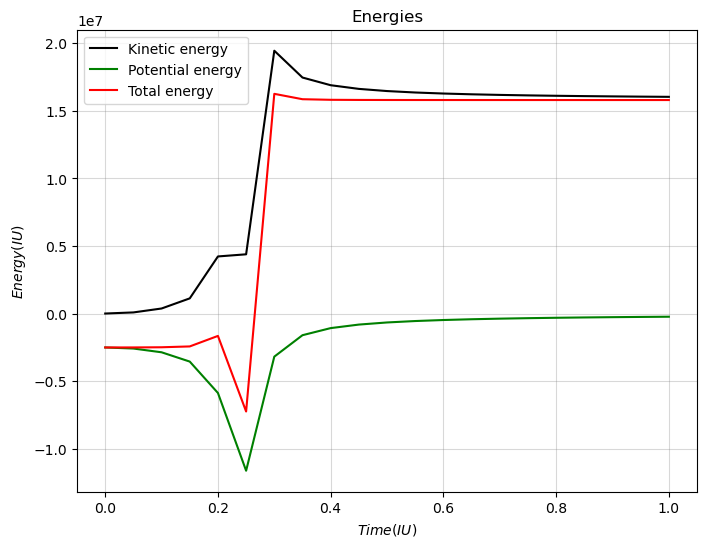

In [13]:
fig2 = plt.figure(figsize=(8,6))
ax2 = fig2.gca()
ax2.grid(alpha=0.3, c = 'grey')
ax2.set_xlabel('$Time (IU)$')
ax2.set_ylabel('$Energy (IU)$')
ax2.plot(t, K, label = 'Kinetic energy', c= 'black')
ax2.plot(t, U, label = 'Potential energy', c='green')
ax2.plot(t, E, label = 'Total energy', c='red')
ax2.set_title('Energies')
ax2.legend()

In [14]:
#Evaluate the collapse time from the potential energy minimum 
min_index = np.argmin(U)
t_coll_simulation = t[min_index]
print("Collapse time from simulation:", t_coll_simulation)

Collapse time from simulation: 0.25


### Movie of the simulation

In [20]:
import os
import imageio.v2 as imageio

# Toggle on/off the movie maker
make_movie = True

if make_movie:
    # FOLDERS MANAGING
    movie_dir_path = "movie_01"
    frames_dir_path = os.path.join(movie_dir_path, "frames")
    movie_frame_name_prefix = "snapshot_img_"

    # Create folders to store the movie and its frames
    if not os.path.isdir(movie_dir_path):
        os.makedirs(frames_dir_path)
    
    # Empty the 'frames' folder
    for file_name in os.listdir(frames_dir_path):
        file_path = os.path.join(frames_dir_path, file_name)
        os.remove(file_path)
    
    # Empty the 'movie' folder
    for file_name in os.listdir(movie_dir_path):
        file_path = os.path.join(movie_dir_path, file_name)
        if os.path.isfile(file_path):
            os.remove(file_path)

    # GENERATING FRAMES
    N_frames = len(t)  # Assumiamo che "t" sia la lista dei tempi

    delete_frames = True  # Se vuoi i frames metti False

    fig = plt.figure(figsize=(16, 9))
    ax = fig.add_subplot(projection='3d')
    ax.set_box_aspect(None, zoom=0.9)  # To prevent z-axis label from being cut off

    # For every snapshot (or for some of them depending on the step of the range() call)
    # plot the position of every particle in 3D space
    for i in range(12):
        for j in range(N):
            ax.scatter(x[i][j], y[i][j], z[i][j], color="blue")

        if i == 0:
            x_lim = ax.get_xlim()
            y_lim = ax.get_ylim()
            z_lim = ax.get_zlim()
        
        ax.set_aspect('equal', 'datalim')
        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)
        ax.set_zlim(z_lim)

        ax.set_xlabel("$x$")
        ax.set_ylabel("$y$")
        ax.set_zlabel("$z$")

        # Save the current figure with a proper name
        frame_name = movie_frame_name_prefix + str(i).zfill(5) + ".png"
        frame_path = os.path.join(frames_dir_path, frame_name)
        fig.savefig(frame_path)

        # Clear the axes for the next plot
        ax.clear()

    plt.close()

    # ASSEMBLING FRAMES
    movie_img_files = os.listdir(frames_dir_path)
    movie_img_files = sorted(movie_img_files)

    movie_path = os.path.join(movie_dir_path, "movie.mp4")

    # Use the imageio writer to build the movie by appending to it every frame
    # Default fps is 10
    with imageio.get_writer(movie_path, mode='I', fps=10) as writer:
        for filename in movie_img_files:
            image = imageio.imread(os.path.join(frames_dir_path, filename))  # Get the frame
            writer.append_data(image)  # Append the frame

    # Delete individual frames if requested
    if delete_frames:
        for file_name in os.listdir(frames_dir_path):
            file_path = os.path.join(frames_dir_path, file_name)
            os.remove(file_path)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1600, 900) to (1600, 912) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


### Evaluating other quantities

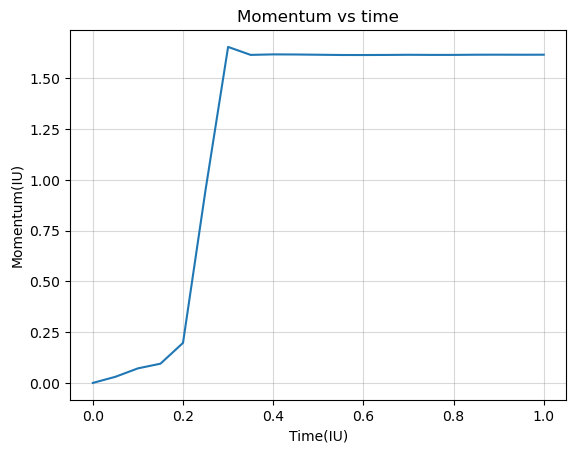

In [15]:
#ATTENZIONE è VETTORIALE
P_i_x = M_i* vx
P_i_y = M_i* vy
P_i_z = M_i* vz
P_tot_x = np.zeros(len(P_i_x))
P_tot_y = np.zeros(len(P_i_x))
P_tot_z = np.zeros(len(P_i_x))

P_tot_i = np.zeros(len(P_i_x))
for i in range(len(P_i_x)):
    P_tot_x[i] = np.sum(P_i_x[i])
    P_tot_y[i] = np.sum(P_i_y[i])
    P_tot_z[i] = np.sum(P_i_z[i])
    P_tot_i[i] = np.sqrt(P_tot_x[i]**2 + P_tot_y[i]**2 + P_tot_z[i]**2)  

plt.plot(t, P_tot_i)
plt.title("Momentum vs time")
plt.xlabel("Time(IU)")
plt.ylabel("Momentum(IU)")
plt.grid(alpha=0.3, c = 'grey')

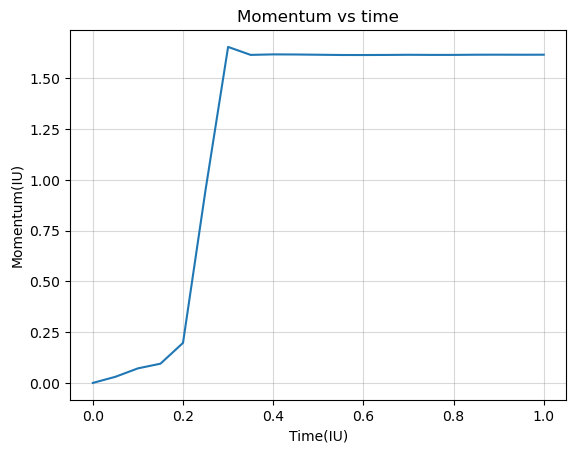

In [16]:
#Evaluation of the momentum of the system
P_tot = M * v_CM
plt.plot(t, P_tot)
plt.title("Momentum vs time")
plt.xlabel("Time(IU)")
plt.ylabel("Momentum(IU)")
plt.grid(alpha=0.3, c = 'grey')

In [17]:
#Evaluating the total angular momentum of the system at each frame 
positions = np.stack((x, y, z), axis=-1)
velocities = np.stack((vx, vy, vz), axis=-1)
L = np.zeros((len(x), 3)) #(frame, number of coords)
for i in range(len(x)):  #For each frame
    for j in range(N):  # For each particle
        L_i = np.cross(positions[i, j], M_i * velocities[i, j])  # Evaluation of angular mom for each particle 
        L[i] += L_i  # Total angular mom at each frame

print(L)

[[ 0.          0.          0.        ]
 [ 0.24037704 -0.20296756  0.24354118]
 [ 0.41932786 -0.14556009  0.89735554]
 [ 0.22877868 -0.10876609  1.27495128]
 [-0.07363775  0.19908686  1.27944125]
 [ 0.309331    0.160902    0.60044917]
 [ 0.7681886  -0.37266285  0.05127105]
 [ 0.61842109 -0.42008658  0.20198508]
 [ 0.53780614 -0.38384837  0.19347514]
 [ 0.58741909 -0.29864515  0.16458922]
 [ 0.61327842 -0.24655895  0.18623232]
 [ 0.582016   -0.2476821   0.21427129]
 [ 0.57484461 -0.20968058  0.21952365]
 [ 0.60653646 -0.15244133  0.2456996 ]
 [ 0.61960514 -0.1460989   0.24594598]
 [ 0.59218309 -0.13847773  0.2372696 ]
 [ 0.56803093 -0.13352267  0.21623303]
 [ 0.5650025  -0.1412974   0.16661919]
 [ 0.56805659 -0.15175078  0.13091622]
 [ 0.56983906 -0.15113888  0.12774442]
 [ 0.58590441 -0.15235329  0.13350992]]


In [18]:
L_tot = np.zeros(len(x)) #Total angular mom at each frame not in components
for i in range(len(L)):
    L_tot[i] = np.sqrt(L[i][0]**2 + L[i][1]**2 + L[i][2]**2)
print(L_tot)    

[0.         0.39785583 1.00113463 1.29987327 1.29693023 0.69434453
 0.85534791 0.77441291 0.68848213 0.67921994 0.68671989 0.66783324
 0.65007915 0.67193239 0.68245502 0.65280453 0.62228945 0.60576788
 0.60237501 0.60322313 0.6199358 ]


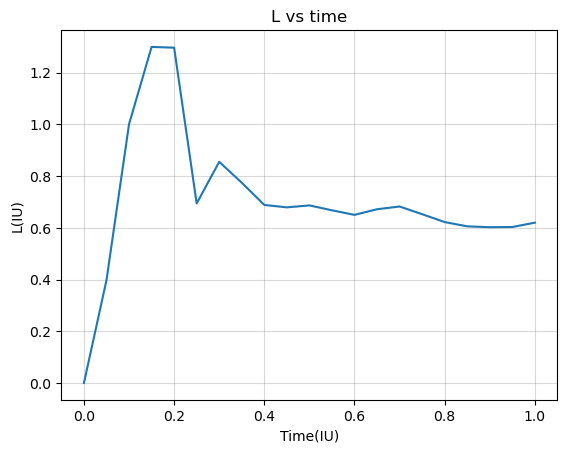

In [19]:
plt.plot(t, L_tot)
plt.title("L vs time")
plt.xlabel("Time(IU)")
plt.ylabel("L(IU)")
plt.grid(alpha=0.3, c = 'grey')

## The same but with physical units

In [ ]:
t_ph = t / t_iu_yr #year
x_ph = x * AU      #cm
y_ph = y * AU
z_ph = z * AU
vx_ph = vx / v_iu_cgs  #cm/s
vy_ph = vy / v_iu_cgs
vz_ph = vz / v_iu_cgs
M_ph = M*M_sun
M_i_ph = M_i*M_sun

In [ ]:
x_1_ph = np.zeros(len(t_ph))
plt.title("X vs time")
plt.xlabel("Time(yr)")
plt.ylabel("X(cm)")
for j in range(0, N, 100):
    for i in range(len(t)):
        x_1_ph[i] = x_ph[i][j]
    plt.plot(t_ph, x_1_ph)

In [ ]:
# We can try to compute the kinetic energy at each step (NON FINITO)
K_i_ph =  M_i * M_sun * (vx_ph**2 + vy_ph**2 + vz_ph**2) / 2

vx_CM = M_i_ph * np.sum(vx_ph) / M_ph
vy_CM = M_i_ph * np.sum(vy_ph) / M_ph
vz_CM = M_i_ph * np.sum(vz_ph) / M_ph

K_CM_ph = M * M_sun * (vx_CM**2 + vy_CM**2 + vz_CM**2) / 2

K_tot_ph = np.zeros(len(K_i_ph))
for i in range(len(K_i_ph)):
    K_tot_ph[i] = np.sum(K_i_ph[i])
    
K_cm_ph = np.zeros(len(K_CM_ph))    
# Respect to the cm
K_cm_ph = K_tot_ph - K_CM_ph